<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/RadNET_CNN_64x64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data Loading

In [1]:
!pip install --upgrade segyio
import segyio
import numpy as np
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import re
import random
from scipy import spatial, signal
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display
import datetime
import tensorflow as tf

     |████████████████████████████████| 92kB 3.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Functions

In [ ]:
########
# Functions for creating synthetic noise

def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1070, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)


########
# Griffin Lim implementation for estimating phase

def griffin_lim(magnitude, iterations, orig_sig, fs, nperseg, noverlap, window):
    """
    Inputs:
      magnitude: the real-value spectrogram array to be converted to signal
      iterations: number of iterations to perform Griffin Lim, suggest several hundred -> 1000
      orig_sig: the original time-domain signal prior to enhancement
            -typical GLA uses random initial signal, using original signal improves stability
      fs, nperseg, noverlap, window: parameters from original STFT


    Returns:
      GLA reconstructed time domain signal

    """
    sig_recon = orig_sig

    error = []

    while iterations > 0:
        _, _, temp_spec = signal.stft(sig_recon, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
        comp_angle = np.angle(temp_spec)
        new_spec = magnitude*np.exp(1j*comp_angle)
        prev_sig = sig_recon
        _, sig_recon = signal.istft(new_spec, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

        if iterations % 10 == 0:
            try:
                rmse = sqrt(sum((sig_recon - prev_sig)**2) / prev_sig.size)
                error.append(rmse)
            except ValueError:
                if len(sig_recon) > len(prev_sig):
                    sig_recon_tmp = sig_recon[:len(prev_sig)]
                    rmse = sqrt(sum((sig_recon_tmp - prev_sig)**2) / prev_sig.size)
                    error.append(rmse)
                if len(sig_recon) < len(prev_sig):
                    prev_sig_tmp = prev_sig[:len(sig_recon)]
                    rmse = sqrt(sum((sig_recon - prev_sig_tmp)**2) / prev_sig_tmp.size)
                    error.append(rmse)
        # print("\rCurrent error for iteration ", iterations,": ", rmse, end='', flush=True)
        
        iterations -= 1

    return sig_recon, error

# Load data Numpy files, create Dataset

In [3]:
##################
## Load numpy files
## Create Tensorflow Dataset
start = time.time()


#---------------------------
# Specify whether to load 'NOISY' data 
# or '3D' data as input

input_data_type = 'NOISY'

# Specify 'magnitude' or 'complex'
model_type = 'magnitude'

if model_type.lower() == 'magnitude':
    OUTPUT_CHANNELS = 1
elif model_type.lower() == 'complex':
    OUTPUT_CHANNELS = 2
else:
    raise ValueError("Specify a valid model type")

# Specify batch size
BATCH_SIZE = 64

#---------------------------




input_data_dir_2D = "/content/drive/My Drive/RadNET/GAN data/Phase2/Training/2D"
input_data_dir_3D = "/content/drive/My Drive/RadNET/GAN data/Phase2/Training/3D"
input_data_dir_Noisy = "/content/drive/My Drive/RadNET/GAN data/Phase2/Training/Noisy"

if model_type == 'magnitude':
    assert 'complex' not in input_data_dir_2D.lower(), "Check data filepaths"
elif model_type == 'complex':
    assert 'complex' in input_data_dir_2D.lower(), "Check data filepaths"

numpy_filepaths_2D = []
for root, dirs, files in os.walk(input_data_dir_2D):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_2D.append(filename)

numpy_filepaths_3D = []
for root, dirs, files in os.walk(input_data_dir_3D):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_3D.append(filename)

numpy_filepaths_Noisy = []
for root, dirs, files in os.walk(input_data_dir_Noisy):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_Noisy.append(filename)

assert len(numpy_filepaths_2D) == len(numpy_filepaths_3D), 'Check 2D and 3D filepaths'
assert len(numpy_filepaths_2D) == len(numpy_filepaths_Noisy), 'Check 2D and Noisy filepaths'

input_dimension = (64, 64, OUTPUT_CHANNELS)
specs_per_training_file = 5000 
total_files =  specs_per_training_file*len(numpy_filepaths_2D)

train_dataset_target = np.zeros((total_files, input_dimension[0], input_dimension[1], input_dimension[2]))
train_dataset_input = np.zeros((total_files, input_dimension[0], input_dimension[1], input_dimension[2]))


for N in range(len(numpy_filepaths_2D)):
    tmp_target_arr = np.load(numpy_filepaths_2D[N])

    if input_data_type == 'NOISY':
        tmp_input_arr = np.load(numpy_filepaths_Noisy[N])
    if input_data_type == '3D':
        tmp_input_arr = np.load(numpy_filepaths_3D[N])

    if model_type.lower() == 'magnitude':
        tmp_target_arr = np.expand_dims(tmp_target_arr, axis=-1)
        tmp_input_arr = np.expand_dims(tmp_input_arr, axis=-1)

    insertion_idx = N * specs_per_training_file

    train_dataset_target[insertion_idx:insertion_idx + specs_per_training_file, :, :, :] = tmp_target_arr
    train_dataset_input[insertion_idx:insertion_idx + specs_per_training_file, :, :, :] = tmp_input_arr



# Scale and shape data

minmax_target = MinMaxScaler()
minmax_input = MinMaxScaler()

train_dataset_target = minmax_target.fit_transform(np.expand_dims(train_dataset_target.flatten(), axis=1))
train_dataset_target = np.reshape(train_dataset_target, (total_files, 
                                                     input_dimension[0], input_dimension[1], input_dimension[2]))

train_dataset_input = minmax_input.fit_transform(np.expand_dims(train_dataset_input.flatten(), axis=1))
train_dataset_input = np.reshape(train_dataset_input, (total_files, 
                                                   input_dimension[0], input_dimension[1], input_dimension[2]))


end = time.time()
print("Time to completion (s): ", round(end-start))

Time to completion (s):  34


In [16]:
##################
## Create validation dataset

val_percent = 0.1
num_vals = int(val_percent * train_dataset_input.shape[0])

val_idxs = random.sample(range(train_dataset_input.shape[0]), num_vals)

val_dataset_input = train_dataset_input[val_idxs,:,:,:]
val_dataset_target = train_dataset_target[val_idxs,:,:,:]

train_dataset_input = np.delete(train_dataset_input, val_idxs, axis=0)
train_dataset_target = np.delete(train_dataset_target, val_idxs, axis=0)

# CNN Model

## Architecture

In [4]:

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result



###############
## Define the input layer
input_layer = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS])
        
down_stack = [
downsample(64, 4, apply_batchnorm=False), # (bs, 32, 32, 64)
downsample(128, 4), # (bs, 16, 16, 128)
downsample(256, 4), # (bs, 8, 8, 256)
downsample(512, 4), # (bs, 4, 4, 512)
downsample(512, 4), # (bs, 2, 2, 512)
downsample(512, 4), # (bs, 1, 1, 512)
]

up_stack = [
upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
upsample(512, 4), # (bs, 16, 16, 1024)
upsample(256, 4), # (bs, 32, 32, 512)
]

initializer = tf.random_normal_initializer(0., 0.02)
last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') # (bs, 256, 256, 3)

x = input_layer

# Downsampling through the model
skips = []
for down in down_stack:
    x = down(x)
    skips.append(x)

skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

x = last(x)


###############
## Define and compile the model
model = tf.keras.Model(inputs=input_layer, outputs=x)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

model.compile(loss=loss_object, optimizer=optimizer)

In [ ]:
## Display graphical model description


tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

## Model training

In [5]:
## Training directory

training_name = 'CNN_Noisy_Magnitude'
checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints/' + training_name

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)


In [ ]:
# Load latest checkpoint if picking up / continuing training 
# Skip if starting from scratch

# Designate which model to load from checkpoint:
# training_name = 'June_Update_    '
checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints/' + training_name

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [9]:
## Run training

EPOCHS=4
BATCH_SIZE=32


class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_epoch_end(*args, **kwargs):
        display.clear_output(wait = True)

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_dir,
    # save_weights_only=True,
    # monitor='val_accuracy',
    # mode='max',
    # save_best_only=True)

save_freq = 2
current_epoch=1
class model_checkpoint_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      try:
          print ('Time taken for epoch {} was {} sec\n'.format(epoch - 1,
                                                      time.time()-epoch_start))
      except:
          pass

      epoch_start = time.time()

      if epoch % save_freq == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
        
callbacks = [ClearTrainingOutput(), model_checkpoint_callback()]

try:
    history = model.fit(x=train_dataset_input, y=train_dataset_target, 
                        validation_data = (val_dataset_input, val_dataset_target), 
                        epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, 
                        callbacks = callbacks)
except NameError:  # catching case with no validation data
    history = model.fit(x=train_dataset_input, y=train_dataset_target, epochs=EPOCHS, verbose=1,
                       batch_size=BATCH_SIZE, callbacks = callbacks)

print("Training Complete!")

3
Training Complete!


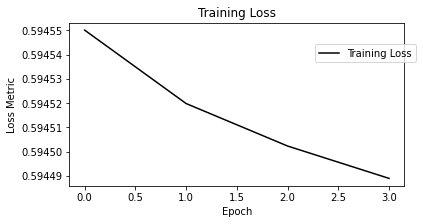

In [18]:
################
## Plot training loss curves

total_loss = history.history['loss']

try:
    total_val_loss = history.history['val_loss']
except KeyError:
    pass


xc = range(EPOCHS)
plot_epoch_start = 0


plt.figure(figsize=(6,3))
plt.plot(xc[plot_epoch_start:], total_loss[plot_epoch_start:], label='Training Loss', c='black')

try:
    lw = 0.7
    ls = '--'
    plt.plot(xc[plot_epoch_start:], total_val_loss[plot_epoch_start:], label='Validation Loss',
            linestyle = ls, linewidth = lw, c='limegreen')
except NameError:
    pass
plt.title("Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss Metric')
plt.legend(bbox_to_anchor=(1.05, .9))
plt.show()

# Run Predictions on Test Dataset

In [ ]:
##################
## Use current model to perform predictions

#------------------
# Specify which dataset version is being created
# Options: 'noise', '2D_to_3D'

dataset_type = 'noise'

# Specify 'magnitude' or 'complex'
model_type = 'magnitude'

#------------------



if dataset_type == 'noise':
    input_data_path = "/content/drive/My Drive/RadNET/GAN data/Phase2/Testing/Testing_Noisy_100.npy"
    input_trace_path = "/content/drive/My Drive/RadNET/GAN data/Phase2/Testing/Testing_Noisy_100_TRACES.npy"
elif dataset_type == '2D_to_3D':
    input_data_path = "/content/drive/My Drive/RadNET/GAN data/Phase2/Testing/Testing_3D_100.npy"
    input_trace_path = "/content/drive/My Drive/RadNET/GAN data/Phase2/Testing/Testing_3D_100_TRACES.npy"

input_data = np.load(input_data_path)
input_traces = np.load(input_trace_path)
num_predictions = input_data.shape[0]

if model_type == 'magnitude':
    assert 'complex' not in input_data_path.lower(), "Check data filepaths"
elif model_type == 'complex':
    assert 'complex' in input_data_path.lower(), "Check data filepaths"



prediction_inputs = minmax_input.transform(np.expand_dims(input_data.flatten(), axis=1))
prediction_inputs = np.reshape(prediction_inputs, (input_data.shape[0], 
                                                   input_dimension[0], input_dimension[1], input_dimension[2]))

prediction_outputs = model.predict(prediction_inputs)
prediction_outputs = minmax_target.inverse_transform(np.expand_dims(prediction_outputs.flatten(), axis=1))
prediction_outputs = np.reshape(prediction_outputs, (num_predictions, 
                                                     input_dimension[0], input_dimension[1], input_dimension[2]))


# output_data_folder = 'June_2021_Noise_v1'
# output_prediction_path = os.path.join("/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Predictions",
#                                       output_data_folder)
# np.save(output_prediction_path, prediction_outputs)

## Visualize prediction vs input and target

In [ ]:
##################
## Load target data
target_path = "/content/drive/My Drive/RadNET/GAN data/Phase2/Testing/Testing_2D_100.npy"
target_data = np.load(target_path)

target_trace_path = "/content/drive/My Drive/RadNET/GAN data/Phase2/Testing/Testing_2D_100_TRACES.npy"
target_traces = np.load(target_trace_path)

if model_type == 'magnitude':
    assert 'complex' not in target_path.lower(), "Check data filepaths"
elif model_type == 'complex':
    assert 'complex' in target_path.lower(), "Check data filepaths"


#------------------
# Choose which example index to show
plot_idx = 30

#------------------



if model_type.lower() == 'magnitude':
    nrows=1
    figsize=(10,4)
    plot_input_data = input_data[plot_idx,:,:]
    plot_target_data = target_data[plot_idx,:,:]
    plot_prediction_data = prediction_outputs[plot_idx,:,:,0]
elif model_type.lower() == 'complex':
    nrows=2
    figsize=(10,8)
    plot_input_data = input_data[plot_idx,:,:,:]
    plot_target_data = target_data[plot_idx,:,:,:]
    plot_prediction_data = prediction_outputs[plot_idx,:,:,:]


##################
## Plot Input - Target - Prediction Spectrograms


colormap='jet'

fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=figsize)

if model_type.lower() == 'magnitude':
    ax[0].imshow(plot_input_data, cmap=colormap)
    ax[0].set_title("Input Data")
    ax[1].imshow(plot_target_data, cmap=colormap)
    ax[1].set_title("Target Data")
    ax[2].imshow(plot_prediction_data, cmap=colormap)
    ax[2].set_title("Prediction Data")
    plt.show()

elif model_type.lower() == 'complex':
    ax[0,0].imshow(plot_input_data[:,:,0], cmap=colormap)
    ax[0,0].set_title("Input Data, Amplitude")
    ax[0,1].imshow(plot_target_data[:,:,0], cmap=colormap)
    ax[0,1].set_title("Target Data, Amplitude")
    ax[0,2].imshow(plot_prediction_data[:,:,0], cmap=colormap)
    ax[0,2].set_title("Prediction Data, Amplitude")
    ax[1,0].imshow(plot_input_data[:,:,1], cmap=colormap)
    ax[1,0].set_title("Input Data, Phase")
    ax[1,1].imshow(plot_target_data[:,:,1], cmap=colormap)
    ax[1,1].set_title("Target Data, Phase")
    ax[1,2].imshow(plot_prediction_data[:,:,1], cmap=colormap)
    ax[1,2].set_title("Prediction Data, Phase")
    plt.show()


##################
## Get time series signals
input_signal = input_traces[plot_idx,:]
target_signal = target_traces[plot_idx,:]

## Zxx parameters - Use same as during data generation
fs = 1 / 0.0000000375     #sample frequency
nperseg = 127        # nperseg/noverlap combo produces 64x32 assuming 1070 samples
noverlap = 92
window = signal.hann(nperseg, sym=False)


##################
## Shape prediction back to proper size
## Use modified Griffim Lim Algorithm to recover time series signal

if model_type.lower() == 'magnitude':

    prediction_data_reduced = np.zeros((plot_prediction_data.shape[0], int(plot_prediction_data.shape[1]/2)))

    for i in range(prediction_data_reduced.shape[0]):
        idx_counter = 0
        for j in range(prediction_data_reduced.shape[1]):
            prediction_data_reduced[i,j] = np.mean(plot_prediction_data[i,idx_counter:idx_counter+2])
            idx_counter += 2

    prediction_data_reduced = np.exp(prediction_data_reduced)

    predicted_signal, _ = griffin_lim(prediction_data_reduced, 300, input_signal, 
                                      fs, nperseg, noverlap, window)
    

##################
## Use iSTFT to create signal for real and imag components

elif model_type.lower() == 'complex':

    prediction_data_reduced = np.zeros((plot_prediction_data.shape[0], int(plot_prediction_data.shape[1]/2),
                                        plot_prediction_data.shape[2]))
    
    real_component = plot_prediction_data[:,:,0]
    imag_component = plot_prediction_data[:,:,1]

    complex_spec = real_component + imag_component*1j

    _, predicted_signal = signal.istft(complex_spec, window = window, 
                                      fs = fs, nperseg = nperseg, noverlap=noverlap)
    

##################
## Trim excess samples from weird iSTFT parameters

if len(input_signal) != len(predicted_signal):

    # assumes predicted signal is always longer than input
    trim_samps = len(predicted_signal) - len(input_signal)

    predicted_signal = predicted_signal[:-trim_samps]



##################
## Make plots

target_color = 'black'
input_color = 'blue'
prediction_color = 'red'

plot_start_idx = 200
plot_stop_idx = 800

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=((12,6)))

print("\nCosine similarity of input and target signal: {}".format(
    round(1 - spatial.distance.cosine(target_signal, input_signal),2)))
print("MSE of input and target signal: {}".format(
    round(np.square(np.subtract(target_signal,input_signal)).mean(),2)))
ax[0].plot(target_signal[plot_start_idx:plot_stop_idx], c=target_color, linewidth=1, label='Target Signal')
ax[0].plot(input_signal[plot_start_idx:plot_stop_idx], c=input_color, linewidth=0.7, label='Input Signal')
ax[0].legend()

print("\nCosine similarity of predicted and target signal: {}".format(
    round(1 - spatial.distance.cosine(target_signal, predicted_signal),2)))
print("MSE of predicted and target signal: {}".format(
    round(np.square(np.subtract(target_signal,predicted_signal)).mean(),2)))
ax[1].plot(target_signal[plot_start_idx:plot_stop_idx], c=target_color, linewidth=1, label='Target Signal')
ax[1].plot(predicted_signal[plot_start_idx:plot_stop_idx], c=prediction_color, linewidth=0.7, label='GAN Signal')
ax[1].legend()

plt.show()